In [ ]:
# Jason Qin
# 04/26/21

# Analyzing Classification Data

Classification results from running TAPE on VDJdb TCR-antigen data.

In [10]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist, hamming
import scipy.stats

from tape.datasets import FastaDataset, pad_sequences
from tape.tokenizers import TAPETokenizer

### Finding Perfect Predictions in Generated Data

In [8]:
data_file = '/group/ag_cmb/scratch/jqin/projects/tape/results/tcr_classification_transformer_21-04-26-17-02-27_872893/eval_predictions_030521_194829.txt'
data = pandas.read_csv(data_file, sep='\t')

In [12]:
# clean and organize data
column_names = ['input', 'target', 'prediction', 'index']
for col in column_names:
    # remove all non-numeric parts of data
    if (data[col] )
    data[col] = data[col].str.replace(r'.*\[', '')
    data[col] = data[col].str.replace(r'\].*', '')
    data[col] = data[col].str.replace(r'        ', ',')
    data[col] = data[col].str.strip()
    
    # convert comma-separated string of ints to list of ints
    data[col] = [np.array([float(y.strip('.')) for y in x]) for x in data[col].str.split(',')]

<ipython-input-12-6ece0dbe828b>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'.*\[', '')
<ipython-input-12-6ece0dbe828b>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'\].*', '')


AttributeError: Can only use .str accessor with string values!

In [4]:
antigens = data['antigen']
predictions = data['prediction']

In [5]:
# reduce length of predictions to be closest to each antigen
# this lets us find the closest match between the targets and the
# generated predictions
truncated_predictions = []
for antigen, pred in zip(antigens, predictions):
    stop_idx = np.where(antigen == 3)[0][0]
    if antigen.shape[0] < pred.shape[0]:
        pred[stop_idx] = 3
        pred = pred[0:(stop_idx+1)]
    truncated_predictions += [pred]

In [26]:
# compare truncated predictions to the known targets
truncated_differences = []
for antigen, pred in zip(antigens, truncated_predictions):
    antigen = np.expand_dims(antigen, 0)
    pred = np.expand_dims(pred, 0)
    truncated_differences += [cdist(antigen, pred, metric='hamming').squeeze()]

In [28]:
# truncated predictions and Hamming distance scores of truncated predictions
# to data frame
data['truncated_prediction'] = truncated_predictions
data['truncated_difference'] = truncated_differences

In [45]:
# find all sequences that were perfectly predicted
perf_preds = data[data['truncated_difference'] == 0]['truncated_prediction']

In [46]:
print('Number of total sequences with predictions: {}'.format(data.shape[0]))
print('Number of perfect predictions (after truncation): {}'.format(len(perf_preds)))

Number of total sequences predicted: 1174
Number of perfect predictions (after truncation): 239


In [3]:
# how many of the unique sequences are there in those that were 
# perfectly predicted?
unique_perf_preds = [list(y) for y in set(tuple(x) for x in perf_preds)]

NameError: name 'perf_preds' is not defined

In [49]:
print('Among perfect predictions, number of unique sequences: {}'.format(len(unique_perf_preds)))

Among perfect predictions, number of unique sequences: 30


In [59]:
# how many times does each of the 30 unique sequences get generated?
unique_pred_counts = []
for pred in unique_perf_preds:
    pred_match = [list(x) == pred for x in perf_preds]
    unique_pred_counts += [sum(pred_match)]

(array([25.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 1. ,  9.3, 17.6, 25.9, 34.2, 42.5, 50.8, 59.1, 67.4, 75.7, 84. ]),
 <BarContainer object of 10 artists>)

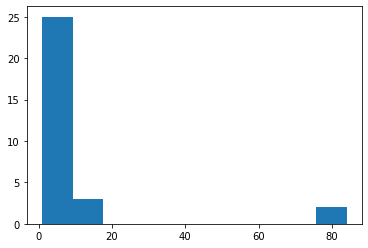

In [63]:
plt.hist(unique_pred_counts)

### Compare Training Data to Validation Data

In [80]:
# relevant data files
data_dir = '/group/ag_cmb/scratch/jqin/projects/tape/data/tcr'
cdr3_train_file = data_dir + '/cdr3_train.fasta'
antigen_train_file = data_dir + '/antigen_train.fasta'
cdr3_valid_file = data_dir + '/cdr3_valid.fasta'
antigen_valid_file = data_dir + '/antigen_valid.fasta'

# set up tokenizer
tokenizer = TAPETokenizer(vocab='iupac')

# load relevant data
antigen_train_data_uncleaned = FastaDataset(antigen_train_file, in_memory=True)

In [81]:
# organize data
antigen_train_data = [list(tokenizer.encode(x['primary'])) for x in antigen_train_data_uncleaned]

In [2]:
# find number of times each unique perfect (truncated) prediction 
# can be found in training data
unique_pred_counts_in_train = []
for pred in unique_perf_preds:
    pred_match = [list(x) == pred for x in antigen_train_data]
    unique_pred_counts_in_train += [sum(pred_match)]

NameError: name 'unique_perf_preds' is not defined

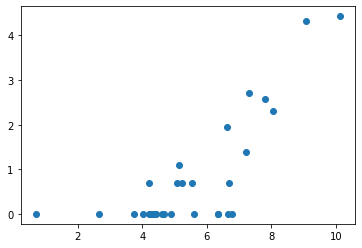

In [90]:
plt.scatter(np.log(unique_pred_counts_in_train), np.log(unique_pred_counts))

In [ ]:
# what is correlation between Hamming distance and number of same
# antigens seen in training data?
all_pred_counts_in_train = []
for pred in truncated_predictions:
    print(pred)
    pred_match = [list(x) == list(pred) for x in antigen_train_data]
    all_pred_counts_in_train += [sum(pred_match)]

[ 2 17 15 22  5 19 25 13 23 19  3]
[ 2 11 13 15 11 10 25 10 23 15  3]
[ 2 11 13 15 11 10 25 10 23 15  3]
[ 2 11 13 15 11 10 25 10 23 15  3]
[ 2 14 15 11 11  5 15 20  5 14  3]
[ 2 11 19 11 12  9  5 21 10 19  3]
[ 2 14 15 25  5 15 11 13 17  5 25  3]
[ 2 17  9 11 25  5  5 10 21 14  3]
[ 2 11 16 10 17 16 15 22 23 25  3]
[ 2 14 15 22  5 16 15 20  5 16  3]
[ 2 23 23 21  9 22 15 17 19  3]
[ 2 14 15 25  5 15 11 13 17  5 25  3]
[ 2 14 15 11 11  5 15 20  5 14  3]
[ 2 28 15 20 19 20 23 20 19 15  3]
[ 2 11 23 22 11 22 19 13 25 17 21  3]
[ 2 14 15 11 25  5 15  8  5 22  3]
[ 2 14 15 11 11  5 15 20  5 14  3]
[ 2 14 15 11 11  5 15 20  5 14  3]
[ 2 11 19  9 19 15 19 20  5 23  3]
[ 2 15 22 28 26 17 20 16 23  5  9 20  5 23  3]
[ 2 11 15 17 14 13 25 21 16 28 21  3]
[ 2  9 19 15 19 20 11 20 15 23  5  3]
[ 2 11  5  8 21 10 20 21 23 15  3]
[ 2 17  9 22 25  9  5  5 17  3]
[ 2  9  5  5 11 13 11 15  8 19 25  3]
[ 2 14 15 22  5 16 15 20  5 16  3]
[ 2 21 15 21 21 19 25  5 19 25  3]
[ 2 23 19 21 25 23  7 17 17  7 

In [1]:
all_pred_counts_in_train

NameError: name 'all_pred_counts_in_train' is not defined